# Using predictive covariates to estimate time trends with DisMod-MR

The goal of this document is to demonstrate how DisMod-MR can produce estimates of time trends using predictive covariates.

To demonstrate this clearly, I have used simulated data: the true age pattern is linear, and prevalence levels vary over time in a way completely explained by covariates $x_1$ and $x_2$.  $x_1$ is increasing roughly linearly over time, while $x_2$ is changing randomly over time.

In [1]:
import numpy as np, matplotlib.pyplot as plt, pymc as mc, pandas as pd, dismod_mr

In [2]:
np.random.seed(123456)

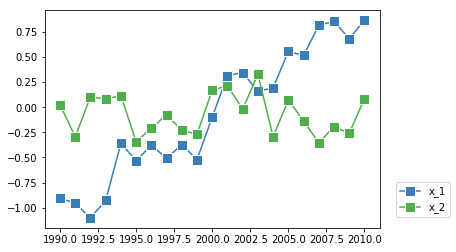

In [3]:
# range of time for simulation
years = np.arange(1990,2011)

# covariates that completely explain variation of prevalence over time
x_1 = mc.rnormal((years-2000) / 10., .2**-2)
x_2 = mc.rnormal(0.*years, .2**-2)

# these covariates change roughly linearly over time
plt.plot(years, x_1, 's-', color=dismod_mr.plot.colors[1], mec='w', ms=10, label='x_1')
plt.plot(years, x_2, 's-', color=dismod_mr.plot.colors[2], mec='w', ms=10, label='x_2')
plt.legend(loc=(1.05,.05));

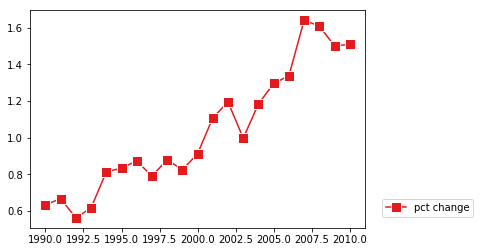

In [4]:
# the percent change over time will be a linear combination of x_1 and x_2
plt.plot(years, np.exp(.5 * x_1 - .25 * x_2), 's-', color=dismod_mr.plot.colors[0], mec='w', ms=10, label='pct change')
plt.legend(loc=(1.05,.05));

In [5]:
# simulate data
n = 100

data = dict(age=np.random.randint(0, 10, size=n)*10,
            year=np.random.randint(1990, 2010, size=n))
data = pd.DataFrame(data)

data['x_1'] = x_1[np.array(data.year-1990)]
data['x_2'] = x_2[np.array(data.year-1990)]

data['value'] = (.1 + .001 * data.age) * np.exp(.5 * data.x_1 - .25 * data.x_2)
data['data_type'] = 'p'

data['age_start'] = data.age
data['age_end'] = data.age+10

data['area'] = 'all'
data['sex'] = 'total'

data['standard_error'] = -99
data['upper_ci'] = np.nan
data['lower_ci'] = np.nan
data['effective_sample_size'] = 1.e8

data.value = np.clip(data.value, 0, 1)


# build the dismod_mr model
dm = dismod_mr.data.ModelData()

dm.parameters['p'] = dict(parameter_age_mesh=[0,100], level_bounds={'lower': 0.0, 'upper': 1.0},
                          level_value={'age_after': 100, 'age_before': 0, 'value': 0.},
                          heterogeneity='Slightly',
                          fixed_effects={'x_sex': dict(dist='Constant', mu=0)})

# fit and predict full model
dm.input_data = data

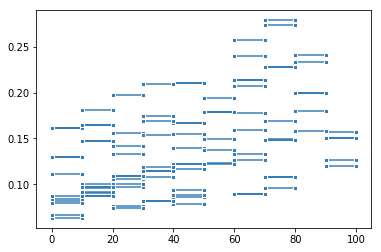

In [6]:
dm.plot('p')

In [7]:
dm.setup_model('p', rate_model='neg_binom')

using stored FE for beta_p_x_sex x_sex {'dist': 'Constant', 'mu': 0}


/ihme/homes/abie/projects/2019/dismod_mr/dismod_mr/model/covariates.py:84: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  U = U.select(lambda col: (U[col].max() > 0) and (model.hierarchy.node[col].get('level') > model.hierarchy.node[root_area]['level']), axis=1)  # drop columns with only zeros and which are for higher levels in hierarchy
/ihme/homes/abie/projects/2019/dismod_mr/dismod_mr/model/covariates.py:98: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  U = U.select(lambda col: 1 <= U[col].sum() < len(U[col]) or col in keep, axis=1)
/ihme/homes/abie/projects/2019/dismod_mr/dismod_mr/model/covariates.py:187: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  X = input_data.select(lambda col: col.startswith('x_'), axis=1)
/ihme/homes/

In [8]:
%time dm.fit(how='mcmc', iter=2_000, burn=1_000, thin=1)

finding initial values
. . . 
finding MAP estimate

finding step covariances estimate

resetting initial values (1)
. . . 
resetting initial values (2)

mare: 0.0
sampling from posterior

CPU times: user 18.4 s, sys: 12.3 ms, total: 18.4 s
Wall time: 18.9 s


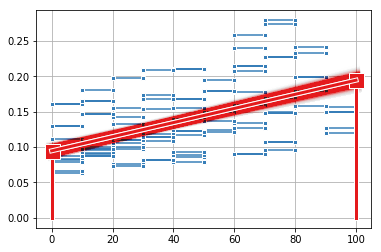

In [9]:
dm.plot('p')
plt.grid();

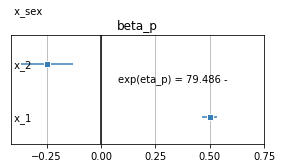

In [10]:
dismod_mr.plot.effects(dm, 'p', figsize=(10,2))
plt.xticks(np.arange(-.25,1,.25))
plt.grid();

This shows the model is hooked up right... the variation in the data is completely explained by the covariates, and the levels and effect coefficients have been recovered from 100 data points.

To use the `dm.predict_for` method, we need to fill in values in `dm.output_template`:

In [11]:
dm.output_template

,data_type,area,sex,year,pop


In [12]:
dm.output_template = pd.DataFrame(dict(year=years, x_1=x_1, x_2=x_2))
dm.output_template['sex'] = 'total'
dm.output_template['pop'] = 1  # pop is important for aggregating multiple areal units, but not relevant for this case
dm.output_template['area'] = 'all'

In [13]:
dm.predict_for('p', 'all', 'total', 2_000).mean()

0.13194908578837536

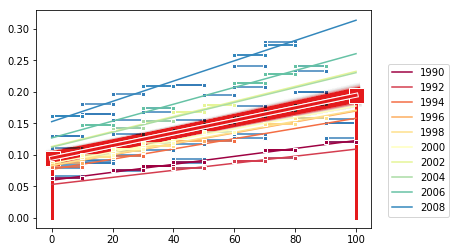

In [14]:
dm.plot()
for y in range(1990,2010,2):
    color = plt.cm.Spectral((y-1990.)/20.)
    plt.plot(dm.predict_for('p', 'all', 'total', y).mean(0), color=color, label=str(y))
    dismod_mr.plot.data_bars(dm.input_data[dm.input_data.year == y], color=color, label='')
plt.legend(loc=(1.05,.05));

In [15]:
import importlib

In [16]:
importlib.reload(dismod_mr.plot)

<module 'dismod_mr.plot' from '/ihme/homes/abie/projects/2019/dismod_mr/dismod_mr/plot.py'>

To really see how well this is predicting, we can look at the residuals:

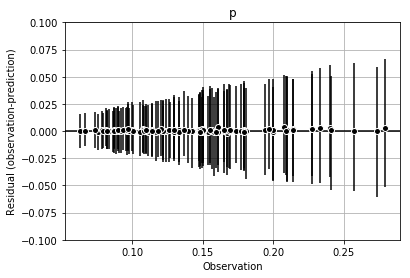

In [17]:
importlib.reload(dismod_mr.plot)

dismod_mr.plot.plot_one_ppc(dm, 'p')
plt.axis(ymin=-.1, ymax=.1);

And the output we are really most interested in is how does the predicted percent change year to year compare to the truth

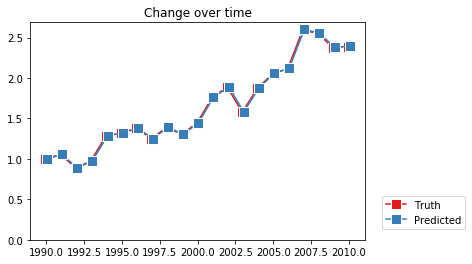

In [18]:
# the percent change over time will be a linear combination of x_1 and x_2
yy = np.exp(.5 * x_1 - .25 * x_2)
yy /= yy[0]
plt.plot(years-.05, yy, 's-', color=dismod_mr.plot.colors[0], mec='w', ms=10, label='Truth')
plt.title('Change over time')

yy = np.array([dm.predict_for('p', 'all', 'total', y).mean() for y in years])
yy /= yy[0]
plt.plot(years+.05, yy,
     's-', color=dismod_mr.plot.colors[1], mec='w', ms=10, label='Predicted')

plt.axis(ymin=0)
plt.legend(loc=(1.05,.05));

What happy results.  Unfortunately, we never have perfect predictors like this.  If we were forced to make due without x_1 or x_2, what would happen?

For starters, we could have _no_ predictive covariates.  In this case, the predictions for every year will have the same mean, and the uncertainty will be blown up to capture all of the unexplained variation.

In [19]:
dm.input_data = dm.input_data.drop(['x_1', 'x_2'], axis=1)
dm.setup_model('p', rate_model='neg_binom')
%time dm.fit(how='mcmc', iter=2000, burn=1000, thin=1)

using stored FE for beta_p_x_sex x_sex {'dist': 'Constant', 'mu': 0}
finding initial values
. . . 
finding MAP estimate

finding step covariances estimate

resetting initial values (1)
. . . 
resetting initial values (2)

mare: 0.21
sampling from posterior

CPU times: user 15.9 s, sys: 16.9 ms, total: 15.9 s
Wall time: 17.1 s


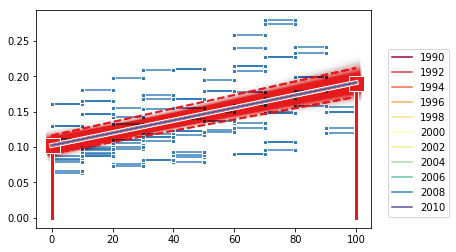

In [20]:
dm.plot()
for y in range(1990,2011,2):
    plt.plot(dm.predict_for('p', 'all', 'total', y).mean(0), color=plt.cm.Spectral((y-1990.)/20.), label=str(y))
    
plt.legend(loc=(1.05,.05));

Now the residuals show the unexplained variation:

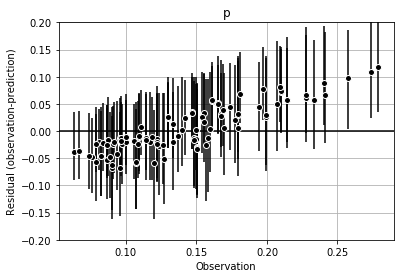

In [21]:
dismod_mr.plot.plot_one_ppc(dm, 'p')
plt.axis(ymin=-.2, ymax=.2);

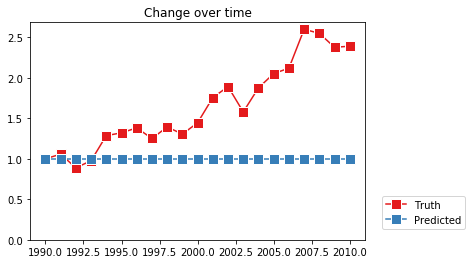

In [22]:
# the percent change over time will be a linear combination of x_1 and x_2
yy = np.exp(.5 * x_1 - .25 * x_2)
yy /= yy[0]
plt.plot(years, yy, 's-', color=dismod_mr.plot.colors[0], mec='w', ms=10, label='Truth')
plt.title('Change over time')

yy = np.array([dm.predict_for('p', 'all', 'total', y).mean() for y in years])
yy /= yy[0]
plt.plot(years, yy,
     's-', color=dismod_mr.plot.colors[1], mec='w', ms=10, label='Predicted')

plt.axis(ymin=0)
plt.legend(loc=(1.05,.05));

Noting that the values are correlated with time, we could use time as a predictive covariate (appropriately normalized).  This would not be perfect, but it would work pretty well in this case.

In [23]:
dm.input_data['x_year'] = (data.year-2000.) / 10.
dm.output_template['x_year'] = (years-2000.) / 10.

dm.setup_model('p', rate_model='neg_binom')
%time dm.fit(how='mcmc', iter=2000, burn=1000, thin=1)

using stored FE for beta_p_x_sex x_sex {'dist': 'Constant', 'mu': 0}
finding initial values
. . . 
finding MAP estimate

finding step covariances estimate

resetting initial values (1)
. . . 
resetting initial values (2)

mare: 0.07
sampling from posterior

CPU times: user 18.2 s, sys: 57.5 ms, total: 18.3 s
Wall time: 19.2 s


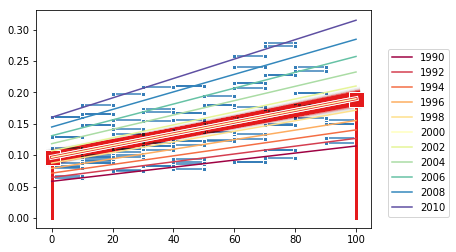

In [24]:
dm.plot()
for y in range(1990,2011,2):
    plt.plot(dm.predict_for('p', 'all', 'total', y).mean(0), color=plt.cm.Spectral((y-1990.)/20.), label=str(y))
    
plt.legend(loc=(1.05,.05));

In this case, the residuals are smaller, but not infinitesimal as in the original fit.

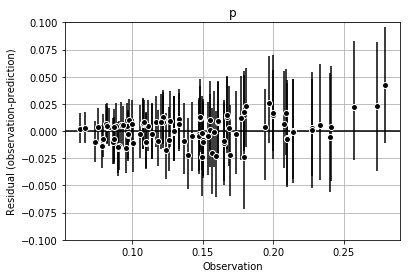

In [25]:
dismod_mr.plot.plot_one_ppc(dm, 'p')
plt.axis(ymin=-.1, ymax=.1);

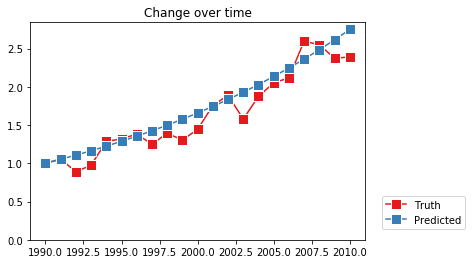

In [26]:
# the percent change over time will be a linear combination of x_1 and x_2
yy = np.exp(.5 * x_1 - .25 * x_2)
yy /= yy[0]
plt.plot(years, yy, 's-', color=dismod_mr.plot.colors[0], mec='w', ms=10, label='Truth')
plt.title('Change over time')

yy = np.array([dm.predict_for('p', 'all', 'total', y).mean() for y in years])
yy /= yy[0]
plt.plot(years, yy,
     's-', color=dismod_mr.plot.colors[1], mec='w', ms=10, label='Predicted')

plt.axis(ymin=0)
plt.legend(loc=(1.05,.05));

If we had only `x_1`, we could use that as the predictive covariate, and it would work slightly better.

In [27]:
dm.input_data = dm.input_data.drop(['x_year'], axis=1)
dm.input_data['x_1'] = x_1[np.array(data.year-1990)]

dm.setup_model('p', rate_model='neg_binom')
%time dm.fit(how='mcmc', iter=2000, burn=1000, thin=1)

using stored FE for beta_p_x_sex x_sex {'dist': 'Constant', 'mu': 0}
finding initial values
. . . 
finding MAP estimate

finding step covariances estimate

resetting initial values (1)
. . . 
resetting initial values (2)

mare: 0.04
sampling from posterior

CPU times: user 18.1 s, sys: 26.7 ms, total: 18.2 s
Wall time: 18.6 s


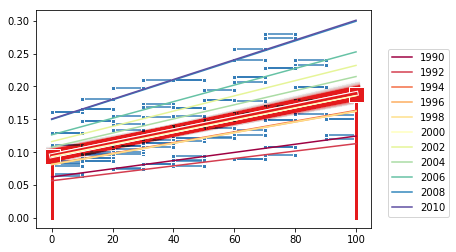

In [28]:
dm.plot()
for y in range(1990,2011,2):
    plt.plot(dm.predict_for('p', 'all', 'total', y).mean(0), color=plt.cm.Spectral((y-1990.)/20.), label=str(y))
    
plt.legend(loc=(1.05,.05));

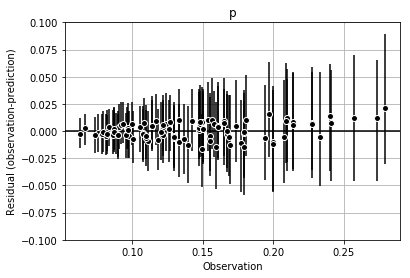

In [29]:
dismod_mr.plot.plot_one_ppc(dm, 'p')
plt.axis(ymin=-.1, ymax=.1);

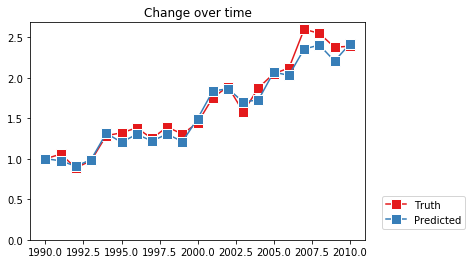

In [30]:
# the percent change over time will be a linear combination of x_1 and x_2
yy = np.exp(.5 * x_1 - .25 * x_2)
yy /= yy[0]
plt.plot(years, yy, 's-', color=dismod_mr.plot.colors[0], mec='w', ms=10, label='Truth')
plt.title('Change over time')

yy = np.array([dm.predict_for('p', 'all', 'total', y).mean() for y in years])
yy /= yy[0]
plt.plot(years, yy,
     's-', color=dismod_mr.plot.colors[1], mec='w', ms=10, label='Predicted')

plt.axis(ymin=0)
plt.legend(loc=(1.05,.05));

We could also use x_1 and year together, which isn't really to our advantage in this case.

In [31]:
dm.input_data['x_year'] = (data.year-2000.) / 10.

dm.setup_model('p', rate_model='neg_binom')
%time dm.fit(how='mcmc', iter=2000, burn=1000, thin=1)

using stored FE for beta_p_x_sex x_sex {'dist': 'Constant', 'mu': 0}
finding initial values
. . . 
finding MAP estimate

finding step covariances estimate

resetting initial values (1)
. . . 
resetting initial values (2)

mare: 0.04
sampling from posterior

CPU times: user 18 s, sys: 28.8 ms, total: 18 s
Wall time: 18.7 s


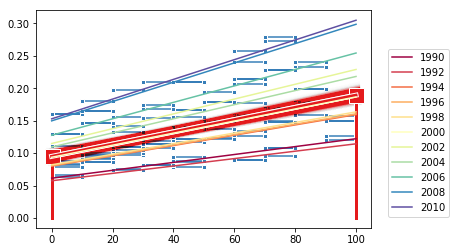

In [32]:
dm.plot()
for y in range(1990,2011,2):
    plt.plot(dm.predict_for('p', 'all', 'total', y).mean(0), color=plt.cm.Spectral((y-1990.)/20.), label=str(y))
    
plt.legend(loc=(1.05,.05));

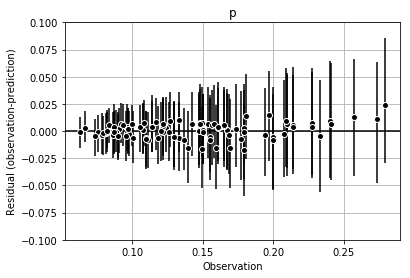

In [33]:
dismod_mr.plot.plot_one_ppc(dm, 'p')
plt.axis(ymin=-.1, ymax=.1);

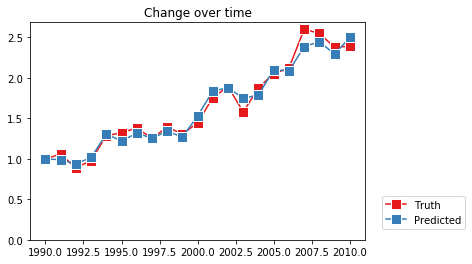

In [34]:
# the percent change over time will be a linear combination of x_1 and x_2
yy = np.exp(.5 * x_1 - .25 * x_2)
yy /= yy[0]
plt.plot(years, yy, 's-', color=dismod_mr.plot.colors[0], mec='w', ms=10, label='Truth')
plt.title('Change over time')

yy = np.array([dm.predict_for('p', 'all', 'total', y).mean() for y in years])
yy /= yy[0]
plt.plot(years, yy,
     's-', color=dismod_mr.plot.colors[1], mec='w', ms=10, label='Predicted')

plt.axis(ymin=0)
plt.legend(loc=(1.05,.05));

Note that including x_year as a covariate when x_1 is already included provides no additional information.  So anything that looks better in this version is actually *overfitting*.

In [35]:
!date

Mon Jun 17 17:29:19 PDT 2019
